# Problem 1

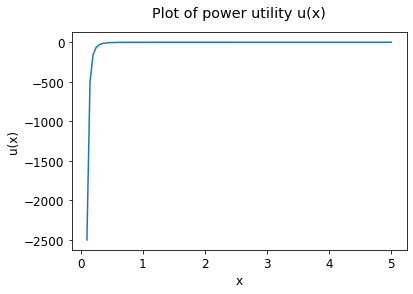

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Plot the power utility
gamma = 5

def u(x):
   return x ** (1-gamma) / (1-gamma)

x = np.linspace(0.1, 5, 100)

plt.plot(x, u(x))
plt.title('Plot of power utility u(x)') 
plt.xlabel("x")
plt.ylabel("u(x)")
plt.rcParams.update({'font.size': 12})

plt.show()

## Part a

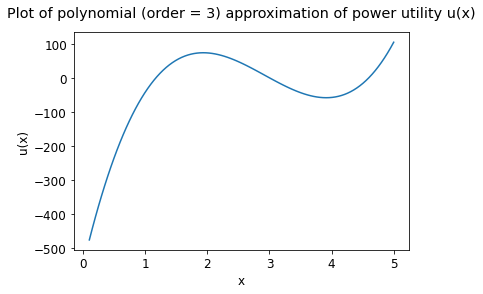

In [15]:
p_fitted = np.polynomial.polynomial.Polynomial.fit(x, u(x), deg=3)
u_p_fitted = p_fitted(x)

plt.plot(x, u_p_fitted)
plt.title('Plot of polynomial (order = 3) approximation of power utility u(x)') 
plt.xlabel("x")
plt.ylabel("u(x)")
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlepad'] = 15

plt.show()

## Part b

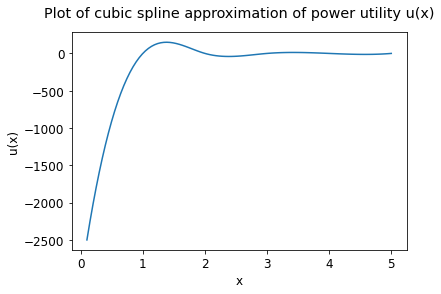

In [16]:
x_fit = np.array([0.1, 1, 2, 3, 4, 5])
cs_fitted = CubicSpline(x_fit, u(x_fit))

plt.plot(x, cs_fitted(x))
plt.title('Plot of cubic spline approximation of power utility u(x)') 
plt.xlabel("x")
plt.ylabel("u(x)")
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlepad'] = 15

plt.show()

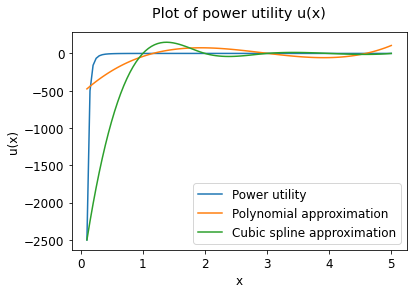

In [17]:
# Combine three plots into one
plt.plot(x, u(x), label ='Power utility')
plt.plot(x, u_p_fitted, label ='Polynomial approximation')
plt.plot(x, cs_fitted(x), label ='Cubic spline approximation')
plt.title('Plot of power utility u(x)') 
plt.xlabel("x")
plt.ylabel("u(x)")
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlepad'] = 15
plt.legend()

plt.show()

## Part c

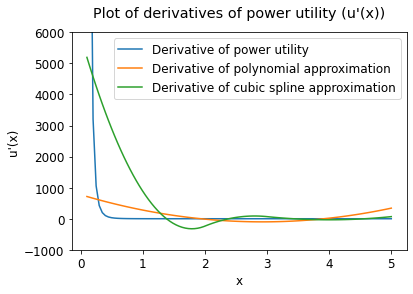

In [21]:
def u_deriv(x):
   return x ** (-gamma)

p_fitted_deriv = p_fitted.deriv(1)
cs_fitted_deriv = cs_fitted.derivative(1)

plt.plot(x, u_deriv(x), label ='Derivative of power utility')
plt.plot(x, p_fitted_deriv(x), label ='Derivative of polynomial approximation')
plt.plot(x, cs_fitted_deriv(x), label ='Derivative of cubic spline approximation')
plt.ylim([-1000, 6000])
plt.title('Plot of derivatives of power utility (u\'(x))') 
plt.xlabel("x")
plt.ylabel("u'(x)")
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlepad'] = 15
plt.legend()

plt.show()

# Problem 2

In [1]:
import numpy as np
import scipy.interpolate
import scipy.optimize as opt
import copy as copy
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [2]:
# Define Parameters
beta = 0.8
R = 1.02
alpha = 1/3

In [4]:
# Define Primitive Functions 

def u(c):
    return np.log(c)

def u_dash(c):
    return 1/c

def f(k):
    return k ** alpha

def f_dash(k):
    return alpha * k ** (alpha - 1)

In [5]:
# Calculate optimal k 

def calculate_optimal_k(R, alpha): 
    return (R / alpha) ** (1 / (alpha - 1))

k_star = calculate_optimal_k(R, alpha)

In [6]:
# Functions to solve FOCs 

def threshold_FOC(w, phi, v_dash):
    target = u_dash(w - (1-phi) * k_star) - beta * R * v_dash(f(k_star) - R * phi * k_star) 
    return target 

def bonds_foc(b, w, phi, v_dash): ## FOC for unconstrained agent
    target = u_dash(w - b - k_star) - beta * R * v_dash(f(k_star) + R*b) 
    return target

def capital_foc(k, w, phi, v_dash):
    target = u_dash(w - (1 - phi) * k) * (1 - phi) - beta * v_dash(f(k) - R * phi * k) * (f_dash(k) - R * phi)
    return target

def solve_for_bonds(w, phi, v_dash, initial_guess):
    b = opt.fsolve(bonds_foc, initial_guess, args = (w, phi, v_dash))
    return b

def solve_for_capital(w, phi, v_dash, initial_guess): 
    k = opt.fsolve(capital_foc, initial_guess, args = (w, phi, v_dash))
    return k

In [7]:
# Set up grid

w_grid = np.linspace(0.05, 3, 100)

# Define initial guess for threshold value of w 

w_threshold = 0.2 ## initial guess

In [8]:
# Process of value function iteration 

def vfi(phi): 

    k_star = calculate_optimal_k(R, alpha)

    # Initialize policy functions 

    b_policy = np.zeros(len(w_grid))
    k_policy = np.ones(len(w_grid)) * k_star
    # Initialize value function

    # v = np.log(w_grid)

    v = np.zeros(len(w_grid))

    # Form a loop to iterate until we are below a specified tolerance

    tol = 1e-6

    error = 1

    while error > tol: 

        # Create a smooth differentiable approximation to the value function

        v_approx = CubicSpline(w_grid, v)

        # Calculate derivative of v_approx

        v_approx_dash = v_approx.derivative(1)

        # Given v_approx_dash, calculate threshold value of w: 

        w_threshold = opt.fsolve(threshold_FOC, 1, args = (phi, v_approx_dash))

        k_guess = k_star 
        b_guess = 0

        v_new = np.zeros(len(w_grid))

        for i in range(len(w_grid)):

            # Calculate policy functions for w < w_threshold, which corresponds to the constrained agent

            if w_grid[i] < w_threshold: 

                k_policy[i] = solve_for_capital(w_grid[i], phi, v_approx_dash, k_guess)
                b_policy[i] = - phi * k_policy[i]

            else: 

                # Calculate policy functions for w >= w_threshold, which corresponds to the unconstrained agent

                b_policy[i] = solve_for_bonds(w_grid[i], phi, v_approx_dash, b_guess)
                k_policy[i] = k_star

            v_new[i] = u(w_grid[i] - b_policy[i] - k_policy[i]) + beta * v_approx(f(k_policy[i]) + R * b_policy[i])

            # Update guess for k and b

            k_guess = k_policy[i]
            b_guess = b_policy[i]

        error = np.max(np.abs(v_new - v))

        v = copy.deepcopy(v_new)

    return v, b_policy, k_policy, w_threshold

C:\Users\tomru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\tomru\AppData\Local\Temp\ipykernel_5408\9155445.py:10: RuntimeWarning: invalid value encountered in power
  return k ** alpha
C:\Users\tomru\AppData\Local\Temp\ipykernel_5408\9155445.py:13: RuntimeWarning: invalid value encountered in power
  return alpha * k ** (alpha - 1)
C:\Users\tomru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


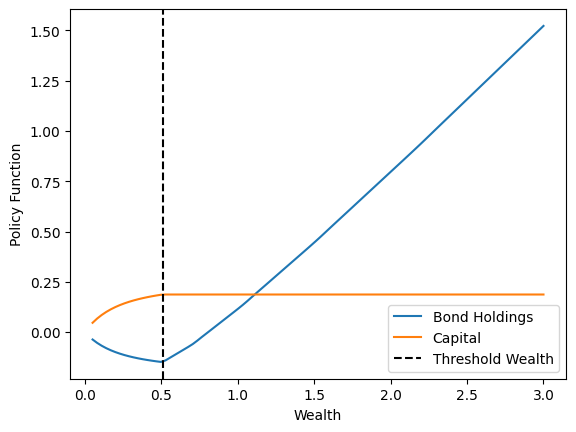

In [9]:
# Plot policy functions and a dotted vertical line at w_threshold
v, b_policy, k_policy, w_thrshold = vfi(0.8)
plt.plot(w_grid, b_policy, label = 'Bond Holdings')
plt.plot(w_grid, k_policy, label = 'Capital')
plt.axvline(x = w_thrshold, color = 'k', linestyle = '--', label = "Threshold Wealth")
plt.xlabel('Wealth')
plt.ylabel('Policy Function')
plt.legend()
plt.show()

C:\Users\tomru\AppData\Local\Temp\ipykernel_5408\9155445.py:10: RuntimeWarning: invalid value encountered in power
  return k ** alpha
C:\Users\tomru\AppData\Local\Temp\ipykernel_5408\9155445.py:13: RuntimeWarning: invalid value encountered in power
  return alpha * k ** (alpha - 1)


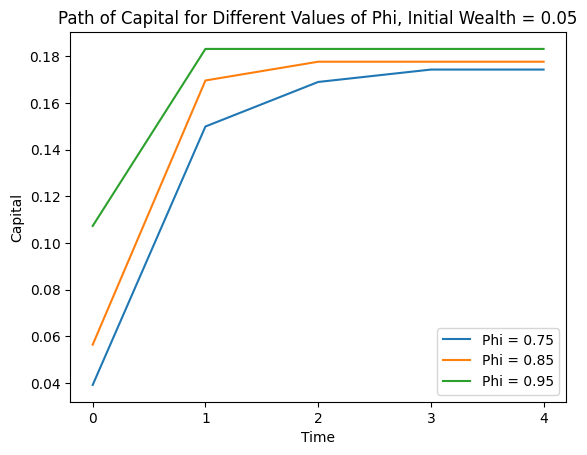

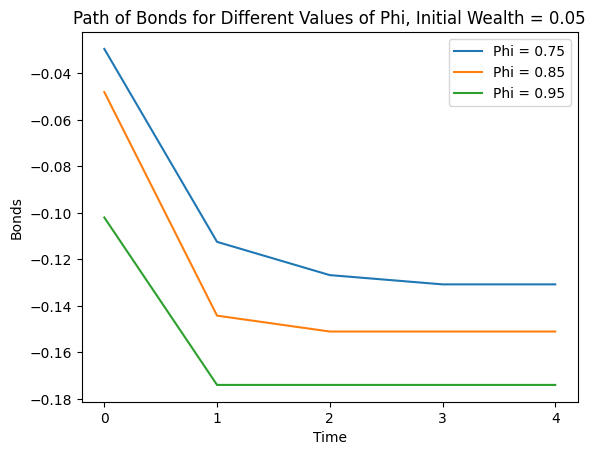

In [10]:
## Find optimal capital policy for differing levels of phi 

phi_grid = np.linspace(0.75, 0.95, 3)

k_policy_grid = np.zeros((len(phi_grid), len(w_grid)))

b_policy_grid = np.zeros((len(phi_grid), len(w_grid)))

for i in range(len(phi_grid)): 

    v, b_policy, k_policy, w_threshold = vfi(phi_grid[i])

    k_policy_grid[i, :] = k_policy

    b_policy_grid[i, :] = b_policy

## Find optimal path of capital over time for different values of phi, 
## starting at w = 0.1 (0th index of w_grid)

k_path_grid = np.zeros((len(phi_grid), 5))
b_path_grid = np.zeros((len(phi_grid), 5))

for i in range(len(phi_grid)):

    k_path_grid[i, 0] = k_policy_grid[i, 0]

    b_path_grid[i, 0] = b_policy_grid[i, 0]

    for j in range(1, 5):

        w_index = np.argmin(np.abs(w_grid - (f(k_path_grid[i, j-1]) + R * b_path_grid[i, j-1])))

        k_path_grid[i, j] = k_policy_grid[i, w_index]
        b_path_grid[i, j] = b_policy_grid[i, w_index]

## Plot paths of capital over time for different values of phi

for i in range(len(phi_grid)):

    plt.plot(k_path_grid[i, :], label = "Phi = " + str(phi_grid[i]))

plt.legend()
plt.xlabel('Time')
plt.ylabel('Capital')
plt.title("Path of Capital for Different Values of Phi, Initial Wealth = 0.05")
plt.xticks(np.arange(0, 5, 1))
plt.show()

## Plot paths of bonds over time for different values of phi

for i in range(len(phi_grid)):

    plt.plot(b_path_grid[i, :], label = "Phi = " + str(phi_grid[i]))

plt.legend()
plt.xlabel('Time')
plt.ylabel('Bonds')
plt.title("Path of Bonds for Different Values of Phi, Initial Wealth = 0.05")
plt.xticks(np.arange(0, 5, 1))
plt.show()